# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [3]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [4]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [5]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())

    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [6]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])

    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Training epoch 14: 100%|██████████| 430/430 [00:02<00:00, 180.22it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.944     0.980     0.961       980
           1      0.966     0.981     0.974      1135
           2      0.930     0.886     0.907      1032
           3      0.896     0.912     0.904      1010
           4      0.912     0.942     0.927       982
           5      0.911     0.857     0.883       892
           6      0.940     0.946     0.943       958
           7      0.922     0.919     0.921      1028
           8      0.877     0.881     0.879       974
           9      0.907     0.898     0.902      1009

    accuracy                          0.921     10000
   macro avg      0.920     0.920     0.920     10000
weighted avg      0.921     0.921     0.921     10000



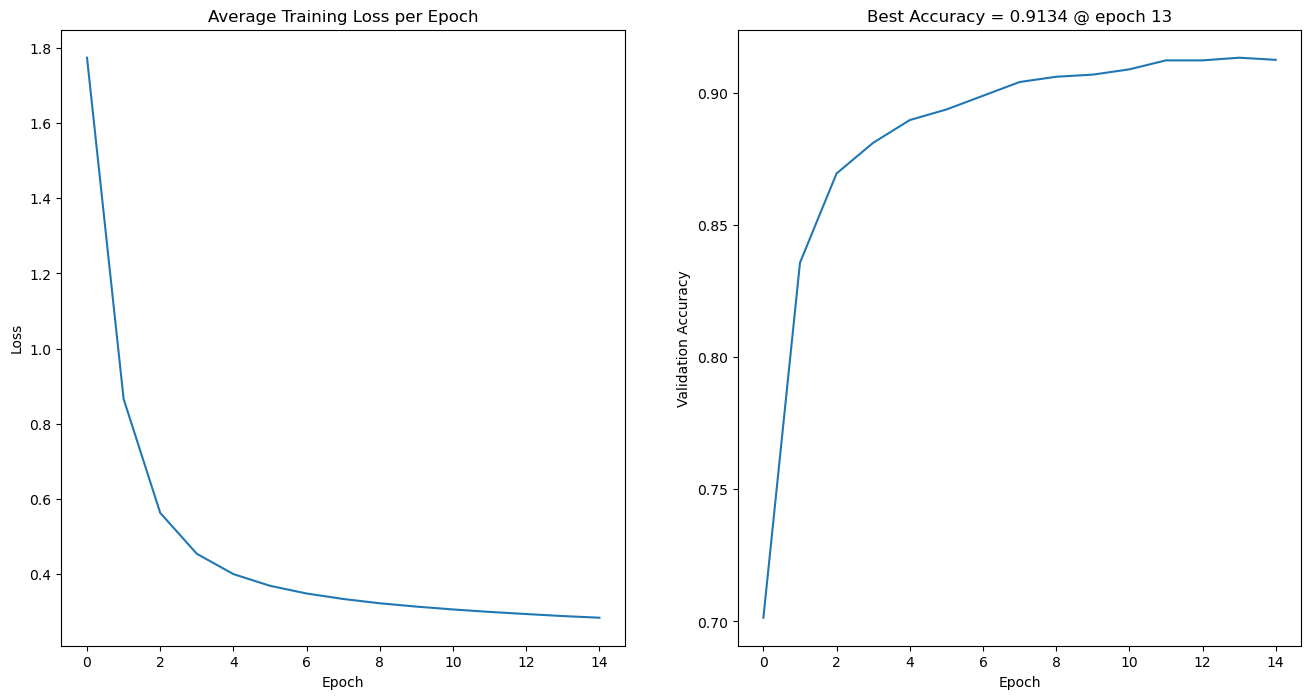

In [7]:
# Training hyperparameters.
device = 'cuda'
epochs = 15
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.# Your code here.

In [8]:
class my_MLP(nn.Module):
    def __init__(self, input_size,output_size,width,depth_size):
        super().__init__()
        self.layers = nn.Sequential()
        # Input layer
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(input_size,width))
        self.layers.append(nn.ReLU())

        # Hidden layers
        for i in range(depth_size):
            self.layers.append(nn.Linear(width,width))
            self.layers.append(nn.ReLU())

        # Output layer
        self.layers.append(nn.Linear(width,output_size))

    def forward(self, x):
        out = self.layers(x)
        return out

In [9]:
def get_accuracy(logits,targets):
    _, predictions = torch.max(logits, dim=-1)
    accuracy = torch.mean(predictions.eq(targets).float())
    return accuracy

In [10]:
import wandb

In [11]:
def train_mlp(model, epochs, dl_train, dl_val , opt, num_layers):


    losses = []
    accuracies = []

    for epoch in range(epochs):
      loss = []
      accuracy = []

      for (x_train, y_train) in tqdm(dl_train, desc=f'Training epoch {epoch}', leave=True):

        model.train()
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        opt.zero_grad()

        logits = model(x_train)
        ls = F.cross_entropy(logits, y_train)
        ls.backward()

        loss.append(ls.item())

        opt.step()

      loss =  np.mean(loss)
      
      for (x_val, y_val) in tqdm(dl_val, desc=f'Eval epoch {epoch}', leave=False):

        model.eval()
        x_val = x_val.to(device)
        y_val = y_val.to(device)

        logits_val = model(x_val)
        acc = get_accuracy(logits_val.detach(),y_val)
        accuracy.append(acc.cpu())

      accuracy = np.mean(accuracy)

      # Appending losses and accuracies

      wandb.log({"loss": loss, "accuracy": accuracy})
      losses.append(loss)
      accuracies.append(accuracy)

    return losses, accuracies

Dichiaro più modelli per più profondità

In [12]:
# Training hyperparameters - locked
device = 'cuda'
epochs = 15
lr = 0.0001
batch_size = 128

# Architecture 1 hyperparameters.
input_size = 28*28
output_size = 10
width = 16
depth_2 = 2

# Architecture 2 hyperparameters - 10x more depth
depth_6 = 6

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate models and optimizers
# Model 1: depth = 2
model_mlp_2 = my_MLP(input_size,output_size,width,depth_2).to(device)
opt_2 = torch.optim.Adam(params=model_mlp_2.parameters(), lr=lr)

# Model 2: depth = 6
model_mlp_6 = my_MLP(input_size,output_size,width,depth_6).to(device)
opt_6 = torch.optim.Adam(params=model_mlp_6.parameters(), lr=lr)

Chiamo train con vari parametri di profondità

In [13]:
wandb.init(project="dl-lab-1", config={
    "epochs": 15,
    "batch_size": 128,
    "learning_rate": 0.0001,
    "architecture": "MLP",
    "depth": 2
})
loss_2, accuracy_2 = train_mlp(model_mlp_2, epochs, dl_train, dl_val, opt_2, depth_2)
wandb.finish()

wandb.init(project="dl-lab-1", config={
    "epochs": 15,
    "batch_size": 128,
    "learning_rate": 0.0001,
    "architecture": "MLP",
    "depth": 6
})
loss_6, accuracy_6 = train_mlp(model_mlp_6, epochs, dl_train, dl_val, opt_6, depth_6)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: magrinigab. Use `wandb login --relogin` to force relogin


Training epoch 14: 100%|██████████| 430/430 [00:02<00:00, 181.78it/s]


accuracy,▁▅▆▇▇▇▇████████
loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,0.91152
loss,0.27947


Training epoch 14: 100%|██████████| 430/430 [00:02<00:00, 179.44it/s]


accuracy,▁▄▆▆▇▇▇▇███████
loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁
accuracy,0.83613
loss,0.52273


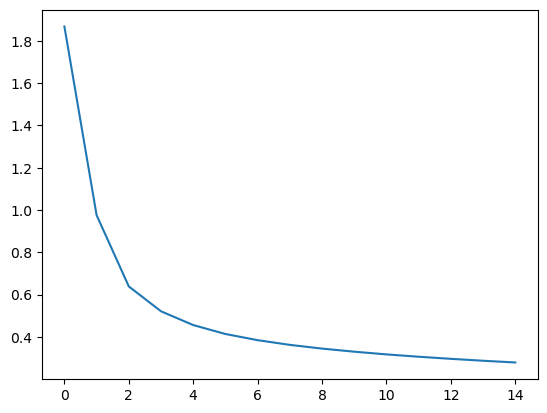

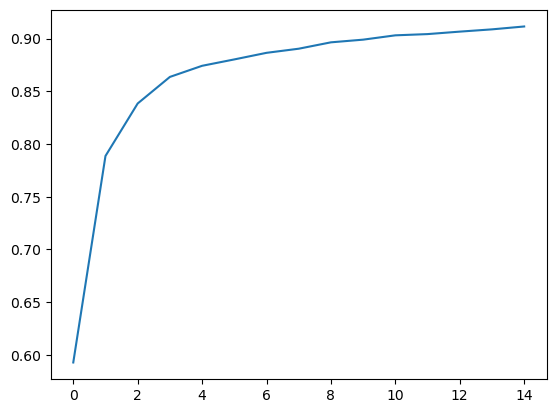

In [14]:
plt.plot(loss_2)
plt.show()

plt.plot(accuracy_2)
plt.show()

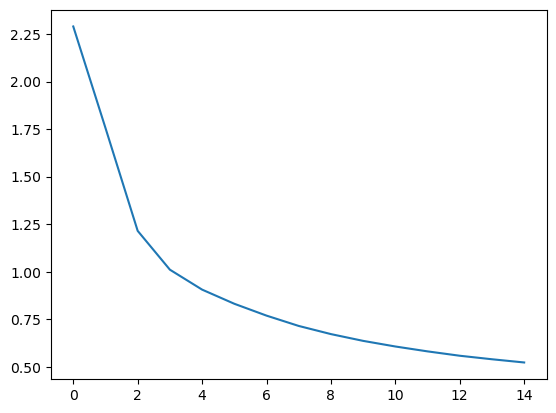

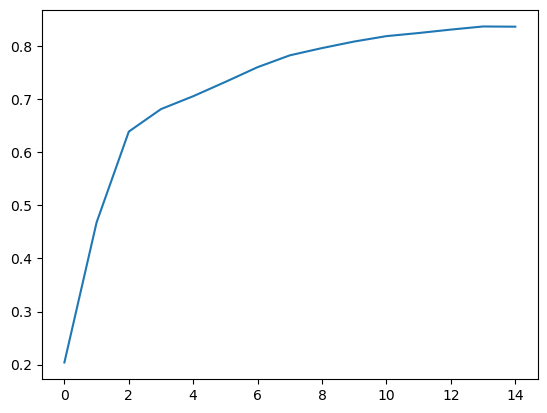

In [15]:
plt.plot(loss_6)
plt.show()

plt.plot(accuracy_6)
plt.show()

E ora test set

In [16]:
def testing(model,dl_test):
  accuracy = []
  for (x_val, y_val) in tqdm(dl_test, leave=False):

        model.eval()
        x_val = x_val.to(device)
        y_val = y_val.to(device)

        logits_val = model(x_val)
        acc = get_accuracy(logits_val.detach(),y_val)
        accuracy.append(acc.cpu())

  accuracy = np.mean(accuracy)
  return accuracy

In [17]:
print(testing(model_mlp_2,dl_test))


0.9176226


In [18]:
print(testing(model_mlp_6,dl_test))

0.8477057


### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 3.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).### Exercise 1.1: A baseline MLP

In [19]:
from torchvision.datasets import CIFAR10

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
     )

batch_size = 32

# Load CIFAR10 train and test.
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])



Files already downloaded and verified
Files already downloaded and verified


Conv block

In [20]:
def conv3x3_pool(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

def conv3x3_same(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
    )

CONVOLUTIONAL ARCHTECTURE

In [66]:
class my_conv(nn.Module):
    def __init__(self,depth_size,residual):
        super().__init__()
        # Input layer
        self.input_layer = nn.Sequential(
          conv3x3_pool(3,64),      #16
          conv3x3_pool(64,128),   #8
          conv3x3_pool(128,256)  #4
        )

        self.layers = nn.Sequential()
        # Hidden layers
        for i in range(depth_size):
            self.layers.append(conv3x3_same(256,256))

        # Output layer
        self.output_layer = nn.Sequential(
              nn.Flatten(),
              nn.Linear(4096,128),
              nn.ReLU(),
              nn.Linear(128,10)
        )

        self.residual = residual

    def forward(self, x):
        out = self.input_layer(x)
        for layer in self.layers:
            residual = out
            out = layer(out)
            if self.residual:
                out = out + residual

        out = self.output_layer(out)
        return out

In [56]:
# Training hyperparameters - locked
device = 'cuda'
epochs = 15
lr = 0.001
batch_size = 32

# Architecture 1 hyperparameters.
width = 16
depth_2 = 2
depth_6 = 6
# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate models and optimizers
# Model 1: depth = 2
model_conv = my_conv(depth_2, True).to(device)
opt_2 = torch.optim.Adam(params=model_conv.parameters(), lr=lr)


In [63]:
model_conv

my_conv(
  (input_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
  )
  (output_layer): Sequential(
    (0): Flatten(start_dim

In [57]:
loss_2, accuracy_2 = train_mlp(model_conv, epochs, dl_train, dl_val, opt_2, depth_2)

Training epoch 14: 100%|██████████| 1407/1407 [00:03<00:00, 420.43it/s]


In [131]:
print('loss_2: ', loss_2)
print('accuracy_2: ', accuracy_2)

loss_2:  [1.3437460184351468, 0.8835180886222186, 0.6994184504799921, 0.571159651602255, 0.46759417334832276, 0.36747454362044374, 0.29505917920539715, 0.23290062224983576, 0.19270793481696166, 0.1650114937678149, 0.14619757244416381, 0.13079437478140987, 0.12114304448098974, 0.11881139645152397, 0.11285868861989529]
accuracy_2:  [0.6289809, 0.70740443, 0.73964965, 0.7571656, 0.7503981, 0.75378186, 0.7563694, 0.75278664, 0.7607484, 0.7561704, 0.74701434, 0.75338376, 0.75, 0.75696653, 0.7621417]


In [132]:
print(testing(model_conv,dl_test))

0.7529952


-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

In [61]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.show()

In [129]:
def train_res(model, epochs, dl_train, dl_val , opt, num_layers):


    losses = []
    accuracies = []

    for epoch in range(epochs):
      loss = []
      accuracy = []
      avg_epoch_grads = []
      
      for (x_train, y_train) in tqdm(dl_train, desc=f'Training epoch {epoch}', leave=True):
        avg_layer_grads = []
        model.train()
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        opt.zero_grad()

        logits = model(x_train)
        ls = F.cross_entropy(logits, y_train)
        ls.backward()
        
        for _, p in model.named_parameters():
            if(p.requires_grad) and ("bias" not in _):
                avg_layer_grads.append(torch.linalg.norm(p.grad.abs().flatten()).cpu())
  

        avg_epoch_grads.append(avg_layer_grads)
        
        loss.append(ls.item())

        opt.step()
  
      loss =  np.mean(loss)
      
      avg_epoch_grads = np.mean(avg_epoch_grads, axis=0)
      plt.plot(avg_epoch_grads)
      plt.title(f'Average gradient per Layer')
      plt.xlabel('Layer')
      plt.ylabel('Average gradient')

      plt.show()

      
      for (x_val, y_val) in tqdm(dl_val, desc=f'Eval epoch {epoch}', leave=False):

        model.eval()
        x_val = x_val.to(device)
        y_val = y_val.to(device)

        logits_val = model(x_val)
        acc = get_accuracy(logits_val.detach(),y_val)
        accuracy.append(acc.cpu())

      accuracy = np.mean(accuracy)

      # Appending losses and accuracies

      wandb.log({"loss": loss, "accuracy": accuracy})
      losses.append(loss)
      accuracies.append(accuracy)

    return losses, accuracies

Training epoch 0:   0%|          | 0/1407 [00:00<?, ?it/s]

Training epoch 0: 100%|██████████| 1407/1407 [00:06<00:00, 217.07it/s]


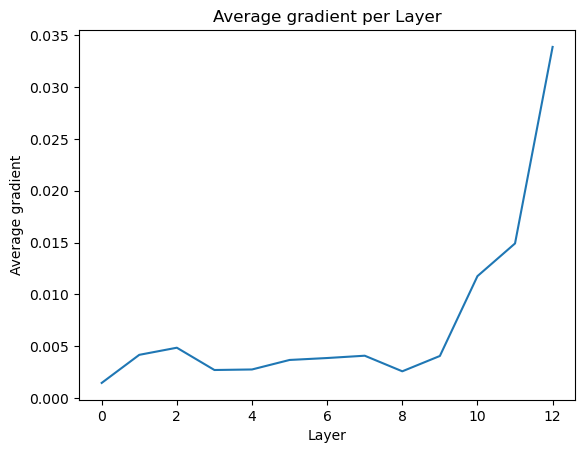

Training epoch 1: 100%|██████████| 1407/1407 [00:06<00:00, 224.18it/s]


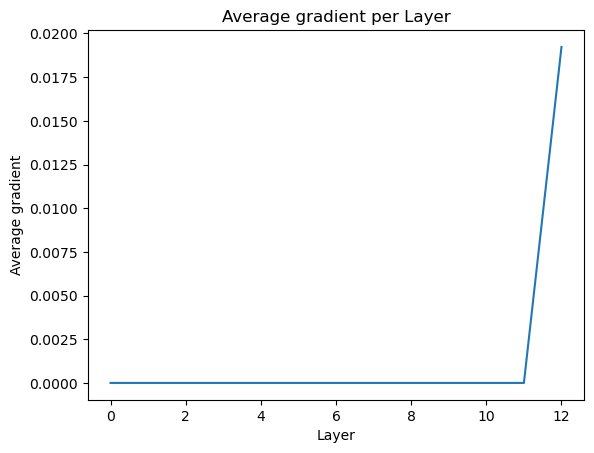

Training epoch 2: 100%|██████████| 1407/1407 [00:06<00:00, 222.84it/s]


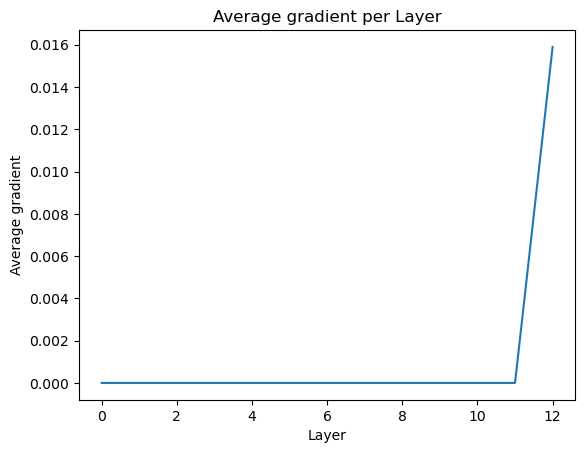

Training epoch 0: 100%|██████████| 1407/1407 [00:06<00:00, 215.10it/s]


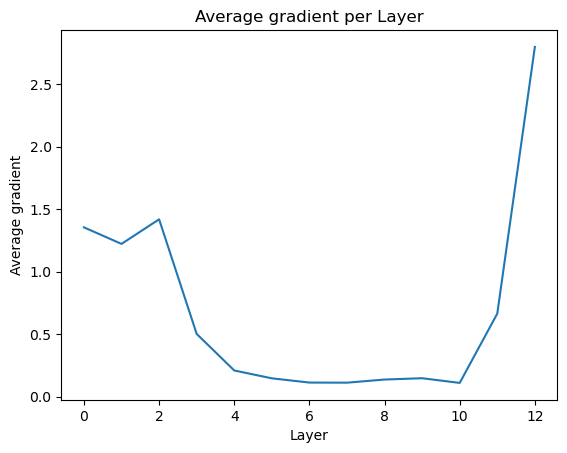

Training epoch 1: 100%|██████████| 1407/1407 [00:06<00:00, 218.11it/s]


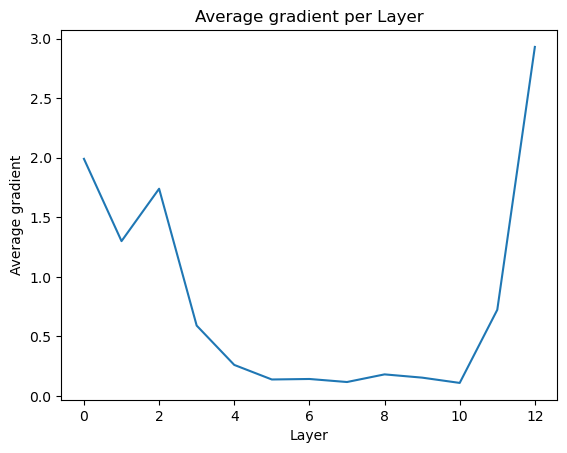

Training epoch 2: 100%|██████████| 1407/1407 [00:06<00:00, 220.64it/s]


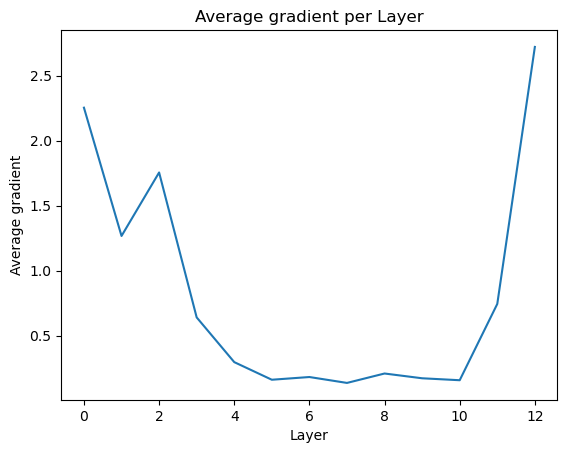

In [130]:
# Hidden layers depth - deep
epochs = 3
depth_8 = 8
model_conv_8 = my_conv(depth_8, residual = False).to(device)
opt_8 = torch.optim.Adam(params=model_conv_8.parameters(), lr=lr)
loss_8, accuracy_8 = train_res(model_conv_8, epochs, dl_train, dl_val, opt_8, depth_8)


# Deep recursive
model_conv_8res = my_conv(depth_8, residual = True).to(device)
opt_8_res = torch.optim.Adam(params=model_conv_8res.parameters(), lr=lr)

loss_8_res, accuracy_8_res = train_res(model_conv_8res, epochs, dl_train, dl_val, opt_8_res, depth_8)


### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

FULLY CONVOLUTIONAL

In [153]:
class my_fully_conv(nn.Module):
    def __init__(self,depth_size,residual):
        super().__init__()
        # Input layer
        self.input_layer = nn.Sequential(
          conv3x3_pool(3,64),
          conv3x3_pool(64,128),
          conv3x3_pool(128,256)
        )

        self.layers = nn.Sequential()
        # Hidden layers
        for i in range(depth_size):
            self.layers.append(conv3x3_same(256,256))

        # Output layer
        self.output_layer = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=4, stride=1, padding=0), 
            nn.ReLU(),
            nn.Conv2d(128, 10, kernel_size=1, stride=1, padding=0)   
        )
        self.residual = residual
        self.maxpool = nn.MaxPool2d(1)

    def forward(self, x):
        out = self.input_layer(x)

        for layer in self.layers:
            residual = out
            out = layer(out)
            if self.residual:
                out = out + residual
        
        out = self.output_layer(out)
        out = self.maxpool(out)
        print(out.shape)
        return out

In [154]:
fully_conv = my_fully_conv(depth_size=depth_8,residual=True).to(device)
opt_8_fully = torch.optim.Adam(params=fully_conv.parameters(), lr=lr)

loss_8_fully, accuracy_8_fully = train_res(fully_conv, epochs, dl_train, dl_val, opt_8_fully, depth_8)

Training epoch 0:   0%|          | 0/1407 [00:00<?, ?it/s]

Training epoch 0:   0%|          | 0/1407 [00:00<?, ?it/s]

torch.Size([32, 10, 1, 1])


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [32]

In [144]:
print(testing(fully_conv,dl_test=dl_test))

0.71755195


### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

In [ ]:
# Your code here.